# **Multiple Linear Regression (4-Predictors)** 

The Goal is to build a realistic, well-documented multiple linear regression model predicting Systolic Blood Pressure (SBP) from 4 predictors:
- `Age` (years)
- `BMI` (kg/m²)
- `Activity` (hours per week) — more activity → lower SBP
- `SaltIntake` (grams/day) — more salt → higher SBP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Visual style
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

## Data Generation


The SBP formula we’re gonna use:

$$
\text{SBP} = \text{intercept} 
+ \beta_{\text{age}} \times \text{Age}
+ \beta_{\text{bmi}} \times \text{BMI}
+ \beta_{\text{activity}} \times \text{Activity}
+ \beta_{\text{salt}} \times \text{SaltIntake}
+ \text{noise}
$$


This time, let's choose realistic coefficient ranges:
- intercept ≈ 80–90
- β_age ≈ 0.35 (mmHg per year)
- β_bmi ≈ 0.9 (mmHg per BMI unit)
- β_activity ≈ -1.2 (mmHg per hour activity/week)
- β_salt ≈ 0.9 (mmHg per gram salt/day)
- noise σ ≈ 7 mmHg

These choices give SBP distributions that look clinically plausible.

In [2]:
np.random.seed(42)

n = 200

# Predictors
age = np.random.randint(25, 81, size=n)                # 25 to 80
bmi = np.random.normal(loc=27, scale=3.5, size=n)      # mean ~27, sd ~3.5
bmi = np.clip(bmi, 18, 36)                             # realistic bounds
activity = np.random.poisson(lam=2.5, size=n)          # typical hours/week distribution
activity = np.clip(activity, 0, 10)
salt = np.random.normal(loc=7.5, scale=2.0, size=n)    # avg ~7.5 g/day
salt = np.clip(salt, 3, 12)

# True coefficients (chosen to be realistic)
intercept = 85.0
beta_age = 0.35
beta_bmi = 0.9
beta_activity = -1.2
beta_salt = 0.9

noise = np.random.normal(0, 7, size=n)                 # sigma = 7 mmHg

sbp = (intercept
       + beta_age * age
       + beta_bmi * bmi
       + beta_activity * activity
       + beta_salt * salt
       + noise)

df = pd.DataFrame({
    "Age": age,
    "BMI": np.round(bmi, 1),
    "Activity": activity,
    "SaltIntake": np.round(salt, 1),
    "SBP": np.round(sbp, 1)
})

df.head()

,Age,BMI,Activity,SaltIntake,SBP
0,63,25.9,2,7.4,131.3
1,76,29.4,2,8.0,153.8
2,53,26.1,5,10.6,122.0
3,39,25.7,4,5.5,111.7
4,67,31.5,4,9.5,142.1


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,51.8850,15.805723,25.0,38.000,52.00,66.000,79.0
BMI,200.0,27.4160,3.426228,18.0,25.175,27.25,30.025,36.0
Activity,200.0,2.4950,1.569167,0.0,1.000,2.00,3.000,8.0
SaltIntake,200.0,7.8485,1.888420,3.0,6.400,7.90,8.900,12.0
SBP,200.0,132.5290,9.994011,109.8,125.325,132.10,139.400,163.6


## 2. Quick EDA (visual checks)

We’ll:
- Plot histograms of each variable (distribution).
- Pairwise scatter plots for predictors vs SBP to confirm linear relationships.

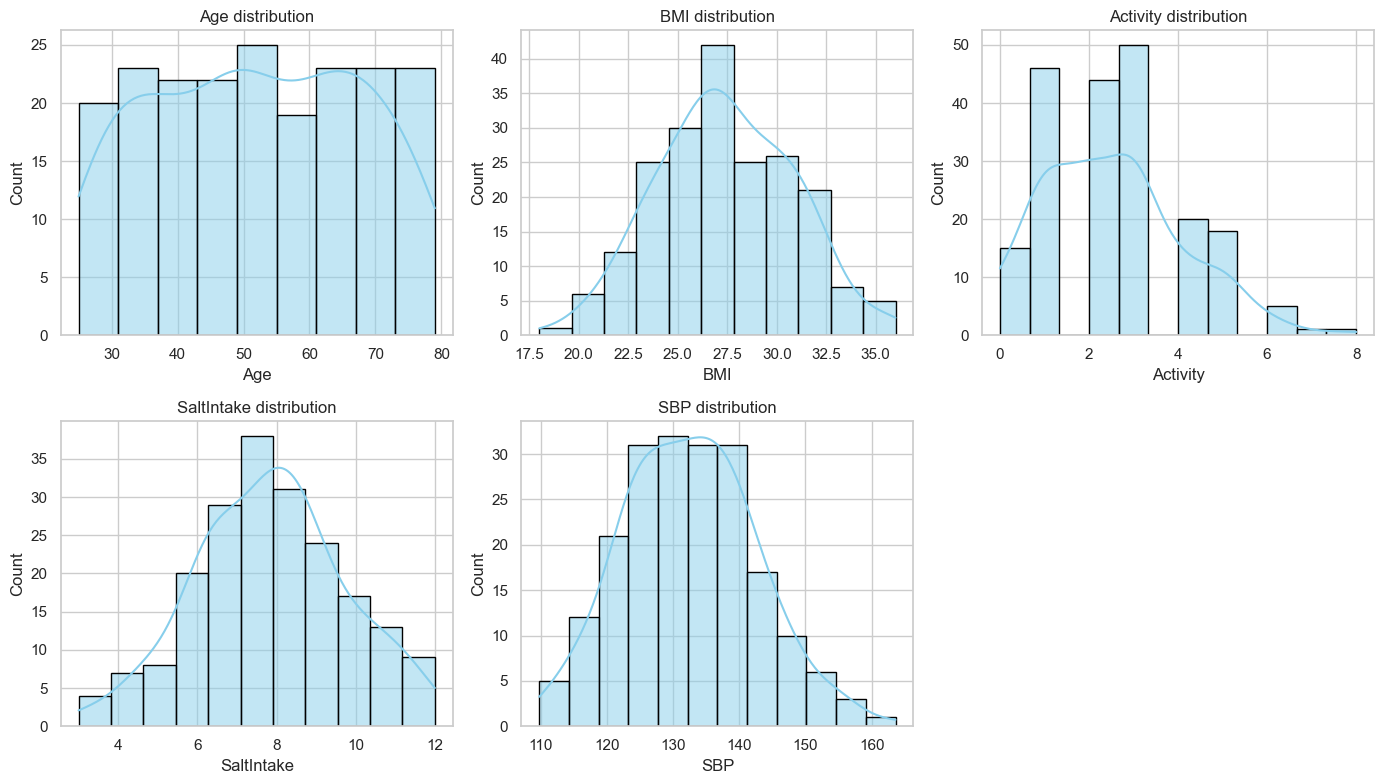

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

cols = ["Age", "BMI", "Activity", "SaltIntake", "SBP"]

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax, color="skyblue", edgecolor="black")
    ax.set_title(f"{col} distribution")

# Hide last subplot (we have 5 plots)
axes[-1].axis("off")
plt.tight_layout()
plt.show()

### What story our visuals telling us?

- The age distribution appears fairly uniform, indicating the sample includes people from a broad range of adult ages, without a strong skew towards younger or older individuals.
- The BMI distribution is bell-shaped, centered around the normal-to-overweight range. This suggests most people in the sample have BMIs between about 23 and 30, with few outliers at either end.​
- The activity distribution is right-skewed, meaning most participants have low to moderate activity scores, with fewer people reporting very high activity levels.​
- Salt intake is roughly normally distributed, meaning most people have moderate intake and fewer individuals consume very low or very high amounts.​
- SBP distribution also forms a bell shape, centering around a typical adult blood pressure range (~130-140 mmHg). Extreme high or low blood pressures are less common.

These plots confirm our simulation behaved as intended.😁

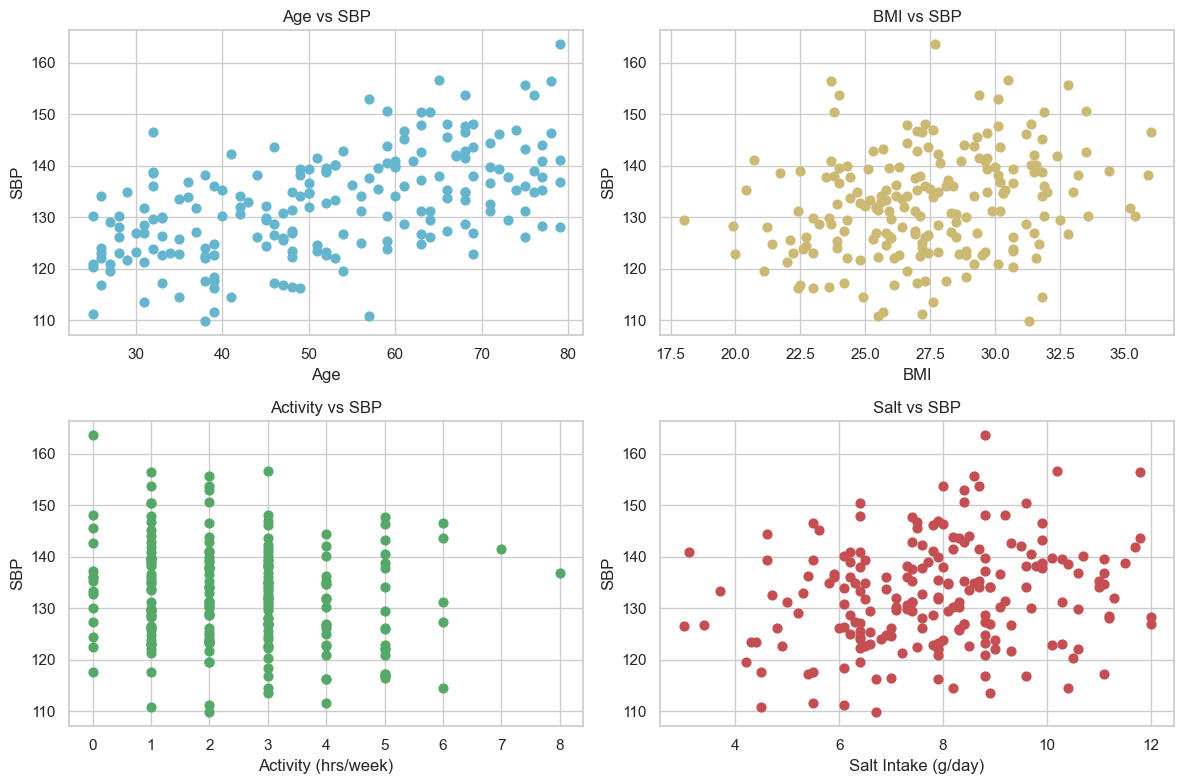

In [5]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(df["Age"], df["SBP"], s=40, c="c")
plt.xlabel("Age")
plt.ylabel("SBP")
plt.title("Age vs SBP")

plt.subplot(2,2,2)
plt.scatter(df["BMI"], df["SBP"], s=40, c="y")
plt.xlabel("BMI")
plt.ylabel("SBP")
plt.title("BMI vs SBP")

plt.subplot(2,2,3)
plt.scatter(df["Activity"], df["SBP"], s=40, c="g")
plt.xlabel("Activity (hrs/week)")
plt.ylabel("SBP")
plt.title("Activity vs SBP")

plt.subplot(2,2,4)
plt.scatter(df["SaltIntake"], df["SBP"], s=40, c="r")
plt.xlabel("Salt Intake (g/day)")
plt.ylabel("SBP")
plt.title("Salt vs SBP")

plt.tight_layout()
plt.show()

- **Age vs SBP:** There is a clear positive trend: as age increases, SBP also tends to rise, indicating that older individuals are more likely to have higher blood pressure.​
- **BMI vs SBP:** The relationship appears weak or unclear, with SBP spread across the entire BMI range and no obvious upward or downward trend. BMI alone may not predict SBP strongly in this group.​
- **Activity vs SBP:** No strong visible trend; people with both high and low activity have varied SBP values, suggesting physical activity (as captured here) isn't a robust SBP predictor in this dataset.​
- **Salt Intake vs SBP:** Again, the scatter plot shows no strong linear association, though a few higher SBP points occur at high salt intakes. Most people, regardless of salt intake levels, have similar SBP.​

While our data suggests that age is the main correlate of SBP, it’s important to remember that in real life, lifestyle factors like physical activity and salt intake can have a strong impact on blood pressure. We actually need a more detailed analysis to tease out these subtler effects. 😂

Since we’re working with our sample data and our main focus is actually on MLR, let’s stick to that for now.

## 3. Fit the multiple linear regression model (OLS)

Model formula:

$$
\text{SBP} = \text{intercept} 
+ \beta_{\text{age}} \times \text{Age}
+ \beta_{\text{bmi}} \times \text{BMI}
+ \beta_{\text{activity}} \times \text{Activity}
+ \beta_{\text{salt}} \times \text{SaltIntake}
+ \text{noise}
$$

We will:
- Fit the model with `statsmodels.OLS`
- Print `summary()` and then interpret the key parts.

In [6]:
X = df[["Age", "BMI", "Activity", "SaltIntake"]]
X = sm.add_constant(X)
y = df["SBP"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SBP   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     43.31
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           5.67e-26
Time:                        01:14:47   Log-Likelihood:                -680.12
No. Observations:                 200   AIC:                             1370.
Df Residuals:                     195   BIC:                             1387.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.3033      5.288     15.376      0.0

### How to read the Model Summary?

Our `summary()` prints lots of info. Let's focus on these key parts:

1. **Coefficients table**  
   - `coef` = estimated `β` for each variable  
     - sign: `+` means positive relationship, `−` means negative  
     - magnitude: how many `mmHg` per unit change  
   - `std err` = standard error of each `β`  
   - `t` and `P>|t|` = t-statistic and p-value (statistical significance)
   - `[0.025    0.975]` = 95% confidence interval for each `β`

2. **R-squared** / **Adj. R-squared**  
   - `R²`: % of variance in SBP explained by predictors  
   - Adjusted `R²` adjusts for number of predictors (preferred when comparing)

3. **F-statistic & Prob (F-statistic)**  
   - Tests whether the model (all predictors together) explains significant variance

4. **Omnibus / Prob(Omnibus), Skew, Kurtosis**  
   - Tests for normality of residuals (useful but sensitive)


### What our OLS regression summary is telling us?

- **Model Fit:**
   * The model explains about `47%` of the variance in SBP (`R-squared = 0.470`, `Adjusted R² = 0.460`), which is moderate.
   * The overall model is statistically significant (`F = 43.31`, `p < 0.001`), indicating that, together, the predictors reliably explain SBP.

- **Coefficients:**
   * **Intercept (`const = 81.3`):** The baseline SBP when all predictors are zero.
   * **Age (`coef = 0.379`, `p < 0.001`):** Each additional year of age is associated with a `0.38 mmHg` increase in SBP, holding other factors constant.
   * **BMI (`coef = 0.918`, `p < 0.001`):** Each unit increase in BMI is linked to a `0.92 mmHg` rise in SBP.
   * **Activity (`coef = -0.941`, `p = 0.005`):** Higher activity is associated with a slight reduction in SBP (`~0.94 mmHg` per unit increase in activity).
   * **Salt Intake (`coef = 1.116`, `p < 0.001`):** Higher salt intake corresponds to an increase of `~1.12 mmHg` in SBP per unit of salt.

All predictors are statistically significant. Age, BMI, and salt intake increase SBP, while higher activity slightly reduces SBP. Even though age seemed the strongest correlate in the scatter plots, this multivariable model now tells us that lifestyle factors like activity and salt intake also have meaningful effects when adjusting for other variables.😀

In [7]:
# Simple train/test split to check generalization
X_all = df[["Age", "BMI", "Activity", "SaltIntake"]]
y_all = df["SBP"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Fit on training data
X_train_sm = sm.add_constant(X_train)
model_train = sm.OLS(y_train, X_train_sm).fit()

# Predict on test
X_test_sm = sm.add_constant(X_test)
y_pred = model_train.predict(X_test_sm)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f} mmHg")

Test RMSE: 7.42 mmHg


### Interpreting RMSE (root mean squared error)

* RMSE measures the average prediction error in the same units as SBP (`mmHg`).
* Our test RMSE of `7.42 mmHg` is close to the noise level we used in the data (`~7 mmHg`), indicating that our model generalizes reasonably well given the inherent variability.
* If RMSE were much larger than the noise (`~7 mmHg`), it would suggest potential model misspecification or high variance.

**Clinical interpretation:**
* An RMSE of `7.42 mmHg` means that, on average, predicted SBP will be off by about `7–8 mmHg`.
* This level of accuracy is acceptable for population-level analyses, but not precise enough for individual clinical decision-making.

It’s all good for now, since we aren’t predicting on actual real-world data yet. So, this level of error is still acceptable for our sample analysis.😅

### Okay, let's take a realistic scenario!

In [8]:
people = pd.DataFrame({
    "Age": [45, 60, 30],
    "BMI": [27, 31, 22],
    "Activity": [3, 1, 6],
    "SaltIntake": [8.0, 10.0, 5.0]
})

people = sm.add_constant(people)
predictions = model.predict(people)
pd.DataFrame({"person": ["A (45y, 27)", "B (60y, 31)", "C (30y, 22)"],
              "predicted_SBP": np.round(predictions, 1)})

,person,predicted_SBP
0,"A (45y, 27)",129.2
1,"B (60y, 31)",142.7
2,"C (30y, 22)",112.8


- **Age effect:** Person B, the oldest (`60 year-old`), has the highest predicted SBP (`142.7 mmHg`), while Person C, the youngest (`30 year-old`), has the lowest (`112.8 mmHg`). This aligns with the positive association between age and SBP observed in the model.
- **BMI effect:** Higher BMI appears to contribute to higher SBP; Person B has both high age and BMI (31) and gets the highest SBP. Person A has moderate BMI (27) and predicted SBP (`129.2 mmHg`), between B and C.
- **Lifestyle effects:** Person C has the highest activity level (`6 hrs/week`) and lowest salt intake (`5.0 g/day`), which contributes to a lower predicted SBP despite being relatively young and lean. Person B has low activity (`1 hr/week`) and high salt intake (`10 g/day`), reinforcing the higher SBP.

The predictions reflect the combined influence of age, BMI, activity, and salt intake, showing how multiple factors interact to determine SBP in a realistic scenario. Even within a small example, the model captures expected patterns: older age, higher BMI, low activity, and higher salt intake all push SBP higher, while younger age, lower BMI, higher activity, and lower salt intake help keep SBP lower.